In [2]:
#Import everything
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

#Indexing functions defined here

def get_inx(meta : dict):  #extract index data
    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    return sort_locs


def count_files(directory): #count files in a directory
    count = 0
    for filename in os.listdir(directory):
        count += 1
        
    return count    


def plate_qc(directory, data_name): #visual check of which well contain cells
    #count the plates
    plotlen = int(math.ceil(count_files(directory)/2))  #math.ceil rounds up to account for an odd number of plates

    fig, ax = plt.subplots(plotlen, 2, figsize = (16,(plotlen*5)))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
    allwells = []

    for a in ywell: #this creates a list of all possible locations
        for b in xwell:
            allwells.append(str(a) + ','+ str(b))

    #Read in files and plot the data for each

    for count, filename in enumerate(os.listdir(directory)):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]

        meta, data = fcsparser.parse(fn, reformat_meta=True)
        
        sort_locs = get_inx(meta)

        for well in allwells:
            if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
                alpha = 0.8
            else:
                alpha = 0.1        #plot empty wells in a lighter shade

            y, x = well.split(',')
            ax[count].scatter(x, y, alpha=alpha, color='gray')      
        ax[count].set_title(plateid)
        ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
        ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
        ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

    fig.suptitle(f'{data_name}', fontsize=14)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_sorted_by_plate.png',dpi=300)     
    
    return

def get_comp_data(directory, plate_key, channel_key, plot = False): #retrieve and compensate flow data, optional plot of comp matrix

    data_dict = {}
    data_dict_comp = {}
    
    #count the plates
    plotlen = int(math.ceil(count_files(directory)/2))  #math.ceil rounds up to account for an odd number of plates
    
    #Set up comp plots
    
    fig, ax = plt.subplots(plotlen, 2, figsize = (12,(plotlen*4)))
    fig.subplots_adjust(hspace = 0.3, wspace=1.5)
    ax = ax.ravel()

    for count, filename in enumerate(os.listdir(directory)):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]

        meta, data = fcsparser.parse(fn, reformat_meta=True)

        sort_locs = get_inx(meta)

        wells = []
        for loc in sort_locs:
            if loc == '':
                continue
            row_index, col = loc.split(',')
            col = str(int(col)+1)
            row = chr(65 + int(row_index)) 
            well = row+col
            wells.append(well)   #Wells is a list of well locations with data derived from the index file

        # Get antibodies and rename with well names
        channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
        #channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx} #can automatically retrieve labels, but causes issues if labelling is inconsistent between all plates

        data.index = pd.Index(wells, name='Sorted well') #Renames index with well name

        # Load compensation
        comp_fields = meta['SPILL'].split(',')
        n = int(comp_fields[0])
        channels = comp_fields[1: n+1]
        matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 

        matrix = numpy.linalg.inv(matrix)

        spill_matrix = pd.DataFrame(
            matrix,
            index=channels,
            columns=channels,
        )  #spill_matrix is the comp matrix

        #Plots compensation matrix
        # Reorder the dyes by wavelength
        wls = [int(x.split('/')[0][-3:]) for x in channels]
        idx = np.argsort(wls)
        spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

        sns.heatmap(spill_by_wls, ax=ax[count])
        ax[count].set_title(plateid)

        #Apply comp and replace column names with antibodies
        data_comp = data.copy()
        compensation = spill_matrix

        for channel in channels:
            data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication

        #Store df and compdf for this iteration as a unique variable - 
        #data_comp.rename(columns = channeld, inplace = True) #Use is automatically assigning channel names
        data_comp.rename(columns = channel_key, inplace = True)
        plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
        data_comp['Well'] = data_comp.index.get_level_values(0)
        data_comp['Plate'] = plate  #add new column with plate name
        data_dict_comp[plate] = data_comp #output df into a dictionary

    fig.tight_layout()  
    
    if plot == False:
        plt.close() 

    alldata_comp = pd.concat(data_dict_comp.values(), axis = 0)
    alldata_comp['Plate_Well'] = alldata_comp['Plate'].astype(str) + '_' + alldata_comp['Well'].astype(str)
    
    return alldata_comp


def flowplot_byplate(compdata, plot_list, logs, gates,  data_name, plot = True, save = False):
    
    sourcedata = compdata.copy()
    plotlen = int(math.ceil(len(plot_list)/2))
    
    plates = sourcedata['Plate'].drop_duplicates().to_list()
    cols = sns.color_palette('husl', n_colors = len(plates))
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['Plate'].map(palette)

    fig, axs = plt.subplots(plotlen,2, figsize = (12,(plotlen*4)))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=1.5)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        for hap in palette:
            point = ax.scatter([], [], color=palette[hap], s = 20, alpha = 0.3, label=hap)
            ax.add_artist(point)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,title='Plate')
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16) 
    
    if save == True:
        fig.savefig(f'../Results/Indexing/{data_name}_flowplot_by_plate.png',dpi=300) 
    
    if plot == False:
        plt.close()
        
def flowplot_bycelltype(assigndata, plot_list, logs, gates,  data_name, plot = True, save = False):
    
    sourcedata = assigndata.copy()
    plotlen = int(math.ceil(len(plot_list)/2))
    
    plates = sourcedata['celltype'].drop_duplicates().to_list()
    cols = sns.color_palette('husl', n_colors = len(plates))
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['celltype'].map(palette)

    fig, axs = plt.subplots(plotlen,2, figsize = (12,(plotlen*4)))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=1.5)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        for hap in palette:
            point = ax.scatter([], [], color=palette[hap], s = 20, alpha = 0.3, label=hap)
            ax.add_artist(point)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,title='Cell type')
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16)   
    
    if save == True:
        fig.savefig(f'../Results/Indexing/{data_name}_flowplot_by_celltype.png',dpi=300) 
    
    if plot == False:
        plt.close()        

def MDS_BM_celltype_assign(source, gates, data_name, save = False):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = source.copy()

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates['CD90-BV421']

    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    mds_sc1 = ['CD34_pos','CD38_neg','IL1RAP_pos']
    mds_sc2 = ['CD34_pos','CD38_neg','CD45RA_pos']
    mds_sc3 = ['CD34_pos','CD38_neg','CD123_pos']
    #hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_pos'] 
    #mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_neg']
    healthy_sc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos']
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']

    col_names = ['mds_sc1', 'mds_sc2','mds_sc2','healthy_sc', 'cmp', 'gmp','mep']
    celltypes = ['MDS_SC', 'MDS_SC','MDS_SC','HEALTHY_SC',  'CMP', 'GMP', 'MEP']
    alltypes = [mds_sc1, mds_sc2, mds_sc3, healthy_sc, cmp, gmp, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))

    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index_refined.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']] #don't need this and it make sthe fucntion fail for bulk cell

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_BMcelltype_assigned.png',dpi=300) 
    
    return data_in

def PB_celltype_assign(source, gates, data_name, save = False):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = source.copy()
    
    #Create boolean matrix based on gates in new columns
    
    data_in['CD45_pos'] = data_in['CD45-FITC'] >= gates['CD45-FITC']
    data_in['IgD_pos'] = data_in['IgD-BB700'] >= gates['IgD-BB700']
    data_in['IgD_neg'] = data_in['IgD-BB700'] < gates['IgD-BB700']
    data_in['CD27_pos'] = data_in['Cd27-APC'] >= gates['Cd27-APC']
    data_in['CD27_neg'] = data_in['Cd27-APC'] < gates['Cd27-APC']
    data_in['CD66b_pos'] = data_in['CD66b-BV421'] >= gates['CD66b-BV421']
    data_in['CD66b_neg'] = data_in['CD66b-BV421'] < gates['CD66b-BV421']
    data_in['CD16_pos'] = data_in['CD16-PE'] >= gates['CD16-PE']
    data_in['CD16_neg'] = data_in['CD16-PE'] < gates['CD16-PE']
    data_in['CD14_pos'] = data_in['CD14-Pe-Cy5'] >= gates['CD14-Pe-Cy5']
    data_in['CD14_neg'] = data_in['CD14-Pe-Cy5'] < gates['CD14-Pe-Cy5']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    nBC = ['CD45_pos','IgD_pos','CD27_neg']
    NE = ['CD45_pos','IgD_neg','CD66b_pos','CD16_pos']
    Mono = ['CD45_pos','IgD_neg','CD66b_neg']

    col_names = ['nBC', 'NE', 'Mono']
    celltypes = ['nBC', 'NE', 'Mono']
    alltypes = [nBC, NE, Mono]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_PBcelltype_assigned.png',dpi=300) 
    
    return data_in


In [3]:
#Haplotype assignment functions now

import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import ternary
from scipy.stats import multinomial

def data_retrieval(sourcefile, pt_init):
    df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
    df = df.stack([0,1,2])
    df = df.reorder_levels([1,0,2,3])
    df = df.to_frame()  #puts everything back in a dataframe
    df.columns = ['Reads']
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Amplicon'] = df.index.get_level_values(2)
    df['Genotype'] = df.index.get_level_values(3)
    df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
    df = df.drop(columns = ['one', 'two'])

    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID') #should this be an input? also in next fucntion
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))

    #Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
    #RN_allele_plate is the key dataset going forward
    pt_allele_plate = df.loc[df['Patient'].isin([pt_init])] #Make df with just RN data
    pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
    pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
    pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)
    
    return pt_allele_plate

def call_haps(data, pt_init, haps, reads,  cutoff):
    
    cond = f'{pt_init}_{haps}'
    print(cond)
    
    if cond == 'RN_2':
        cols = ['RN_RUNX1_c', 'RN_RUNX1_g']
        allcols = ['RN_RUNX1_c','RN_RUNX1_g','RN_SRSF2','RN_TET2a','RN_TET2b_c','RN_TET2b_g']
    elif cond == 'RN_3':
        cols = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']
        allcols = ['RN_RUNX1_c','RN_RUNX1_g','RN_SRSF2','RN_TET2a','RN_TET2b_c','RN_TET2b_g']
    elif cond == 'RN_4':
        cols = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']
        allcols = ['RN_RUNX1_c','RN_RUNX1_g','RN_SRSF2','RN_TET2a','RN_TET2b_c','RN_TET2b_g']
    elif cond == 'EL_3':
        cols = ['EL_SRSF2', 'EL_TET2a', 'EL_TET2b']
        allcols = ['EL_CUX1', 'EL_SRSF2', 'EL_TET2a', 'EL_TET2b', 'EL_TGFB3_c', 'EL_TGFB3_g']
    elif cond == 'EL_4':   
        cols = ['EL_SRSF2', 'EL_TET2a', 'EL_TET2b',  'EL_TGFB3_g']
        allcols = ['EL_CUX1', 'EL_SRSF2', 'EL_TET2a', 'EL_TET2b', 'EL_TGFB3_c', 'EL_TGFB3_g']
    elif cond == 'GR_2': 
        cols = ['GR_TET2a', 'GR_TET2b']
        allcols = ['GR_TET2a', 'GR_TET2b']
    else:
        print('For RN enter 2/3/4 haplotypes, for EL enter 3/4 haplotypes, for GR enter 2 haplotypes')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads for {haps} genes = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    
    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = ['w', 'm']
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols
    
    if 'RN_RUNX1_g' in df2.columns:
        df2.loc[:,'RN_RUNX1_g'].replace({'w':'R','m':'r' }, inplace = True)
        
    if 'RN_SRSF2' in df2.columns:  
        df2.loc[:,'RN_SRSF2'].replace({'w':'S','m':'s' }, inplace = True)
        
    if 'RN_TET2a' in df2.columns:     
        df2.loc[:,'RN_TET2a'].replace({'w':'A','m':'a' }, inplace = True)
        
    if 'RN_TET2b_g' in df2.columns:
        df2.loc[:,'RN_TET2b_g'].replace({'w':'B','m':'b' }, inplace = True)
        
    if 'RN_RUNX1_c' in df2.columns:   
        df2.loc[:,'RN_RUNX1_c'].replace({'w':'C','m':'c' }, inplace = True)
        
    if 'EL_SRSF2' in df2.columns:   
        df2.loc[:,'EL_SRSF2'].replace({'w':'S','m':'s' }, inplace = True)
        
    if 'EL_TET2a' in df2.columns:   
        df2.loc[:,'EL_TET2a'].replace({'w':'A','m':'a' }, inplace = True)
        
    if 'EL_TET2b' in df2.columns:   
        df2.loc[:,'EL_TET2b'].replace({'w':'B','m':'b' }, inplace = True)
        
    if 'EL_TGFB3_g' in df2.columns:   
        df2.loc[:,'EL_TGFB3_g'].replace({'w':'T','m':'t' }, inplace = True)
        
    if 'GR_TET2a' in df2.columns:   
        df2.loc[:,'GR_TET2a'].replace({'w':'A','m':'a' }, inplace = True)
        
    if 'GR_TET2b' in df2.columns:   
        df2.loc[:,'GR_TET2b'].replace({'w':'B','m':'b' }, inplace = True)

    
    df2['Haplotype'] = 'x'

    for idx, row in df2.iterrows():
        
        if cond == 'RN_3':
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_RUNX1_g']
        elif cond == 'RN_4':
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_TET2b_g'] + row['RN_RUNX1_g']
        elif cond == 'RN_2':
            a = row['RN_RUNX1_c'] + row['RN_RUNX1_g']   
        elif cond == 'EL_3':
            a = row['EL_TET2b'] + row['EL_TET2a'] + row['EL_SRSF2']
        elif cond == 'EL_4':
            a = row['EL_TET2b'] + row['EL_TET2a'] + row['EL_SRSF2'] + row['EL_TGFB3_g']
        elif cond == 'GR_2':
            a = row['GR_TET2b'] + row['GR_TET2a']
        
        row['Haplotype'] = row['Haplotype'].replace('x', a)   

    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = cols)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    return df2

def plot_hap_dist_sort_type(data, pt_init, haps, reads, cutoff, save = False): #plot based on cell type (ned to merge output from above)
      
    #rename the input data and work out how many haplotypes it has
    df3 = data.copy()
    haps = len(df3.iloc[0,0])
    cond = f'{pt_init}_{haps}'
    sortcells = df3['Sort_cell_type'].drop_duplicates().to_list()
    cellnumb = len(sortcells)
    plotlen = int(math.ceil((cellnumb +1)/2))
    
    #Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
    fig, axes = plt.subplots(plotlen,2, figsize = (16,plotlen*2))
    fig.subplots_adjust(hspace = 1.2, wspace=.3)
    ax = axes.ravel()
    count = 0

    c = df3['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

    #set up correct variables for the number of input haplotypes
    
    if cond == 'RN_2':
        hap_poss = ['CR', 'Cr', 'cR', 'cr']
        
    elif cond == 'RN_3':
        hap_poss = ['SAR', 'SAr', 'SaR', 'Sar', 'sAR', 'sAr', 'saR', 'sar']

    elif cond == 'RN_4':
        hap_poss = ['SABR', 'SABr', 'SAbR', 'SAbr', 'SaBR', 'SaBr', 'SabR', 'Sabr', 'sABR', 'sABr', 'sAbR', 'sAbr', 'saBR', 'saBr', 'sabR', 'sabr']
      
    elif cond == 'GR_2':
        hap_poss = ['BA', 'Ba', 'bA', 'ba']

    elif cond == 'EL_3':
        hap_poss = ['BAS', 'BAs', 'BaS', 'Bas', 'bAS', 'bAs', 'baS', 'bas']

    elif cond == 'EL_4':
        hap_poss = ['BAST', 'BASt', 'BAsT', 'BAst', 'BaST', 'BaSt', 'BasT', 'Bast', 'bAST', 'bASt', 'bAsT', 'bAst', 'baST', 'baSt', 'basT', 'bast']

    num_col = len(hap_poss)
    cols = sns.color_palette("husl", num_col)     
    color = dict(zip(hap_poss, cols))
    hap_order = {}
    for i, j in enumerate(hap_poss):
        hap_order[1] = j
        
    #if any haplotype is not present, add it into the frame with freq 0 

    for h in hap_poss:
        if h not in str(c['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
            dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
            c = c.append(dfh)
            
    c['order'] = c['hap']
    c = c.replace({'order': hap_order})
    c = c.sort_values(by=['order'])
    d = c['counts'].sum()
    c['proportion'] = c['counts']/d

    sns.barplot(x='hap', y='counts', data = c, palette = color, ax = ax[0], ci = None) #fro scatter add  hue = 'hap'
    ax[0].set_title('All cells') 
    ax[0].set_ylabel('Number of cells', fontsize = 11)
    ax[0].set_xlabel('Haplotype', fontsize = 11)
    ax[0].tick_params(axis='x', labelrotation = 90)

    
    
    for cell in sortcells:
        count += 1
    
        if df3.loc[df3['Sort_cell_type'].isin([cell])].empty == False:

            a = df3.loc[df3['Sort_cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

            #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
            for h in hap_poss:
                if h not in str(a['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
                    dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                    a = a.append(dfh)    

            a['order'] = a['hap']
            a = a.replace({'order': hap_order})
            a = a.sort_values(by=['order'])
            b = a['counts'].sum()
            a['proportion'] = a['counts']/b

            sns.barplot(x='hap', y='counts', data = a, palette = color,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
            ax[count].set_title(str(cell)) 
            ax[count].set_ylabel('Number of cells', fontsize = 11)
            ax[count].set_xlabel('Haplotype', fontsize = 11)
            ax[count].tick_params(axis='x', labelrotation = 90)

        else:
            continue
            
    if save == True:
        fig.savefig(f'../Results/Haplotypes/{pt_init}_{haps}_{reads}_{cutoff}_haplotype_by_sortcell.png',dpi=300)

def plot_index_heatmap(data, title, haps, reads, cutoff, save = False):
    df = data.copy()
    a = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    alltypes = ['HSC','MPP','HEALTHY_SC','CMP',  'GMP','GMP2', 'MEP', 'MDS_SC',  'NE', 'Mono','nBC', 'unassigned']
    col_order = {}            
    for i, typ in enumerate(alltypes):
         col_order[typ] = i

    a = a.T
    a['ct'] = a.index.get_level_values(0)
    a = a.replace({'ct': col_order})
    a = a.sort_values(by=['ct'])
    a = a.drop(columns = ['ct'])
    a = a.T
    b = a.copy()
    a = a * 100 /a.sum(axis = 0)

    fig, ax = plt.subplots(figsize = (16, 6))
    sns.heatmap(data = a, ax = ax, robust = True)
    ax.tick_params(axis='y', labelrotation = 0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)  
    
    x = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    y = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    x = x.sum(axis = 0)
    x = x.to_frame()
    x['order'] = x.index.get_level_values(0)
    x = x.replace({'order': col_order})
    x = x.sort_values(by=['order'])
    x = x.drop(columns = ['order'])
    x['ct'] = x.index.get_level_values(0)
    x.columns = ['number', 'ct']

    
    fig2, ax2 = plt.subplots(figsize = (12.8, 1))
    sns.scatterplot(x = 'ct', y = 'number', data = x, ax = ax2, s = 100, color = 'green')
    ax2.tick_params(axis='x', labelrotation = 90)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.axhline(10, ls = '--', c = 'gray')
    ax2.axhline(100, ls = '--', c = 'gray')
    ax2.set_ylim(1,1001)
    ax2.set_yticks([1,10, 100, 1000])
    ax2.set_yticklabels(['1','10', '100','1000]'])    
    ax2.set_yscale('log') #use this only with scatterplot
    ax2.set_title('Total number of cells for each type')  
    
    if save == True:
        fig.savefig(f'../Results/Haplotypes/{pt_init}_{haps}_{reads}_{cutoff}_haplotype_by_indexcell.png',dpi=300)
    
    return b

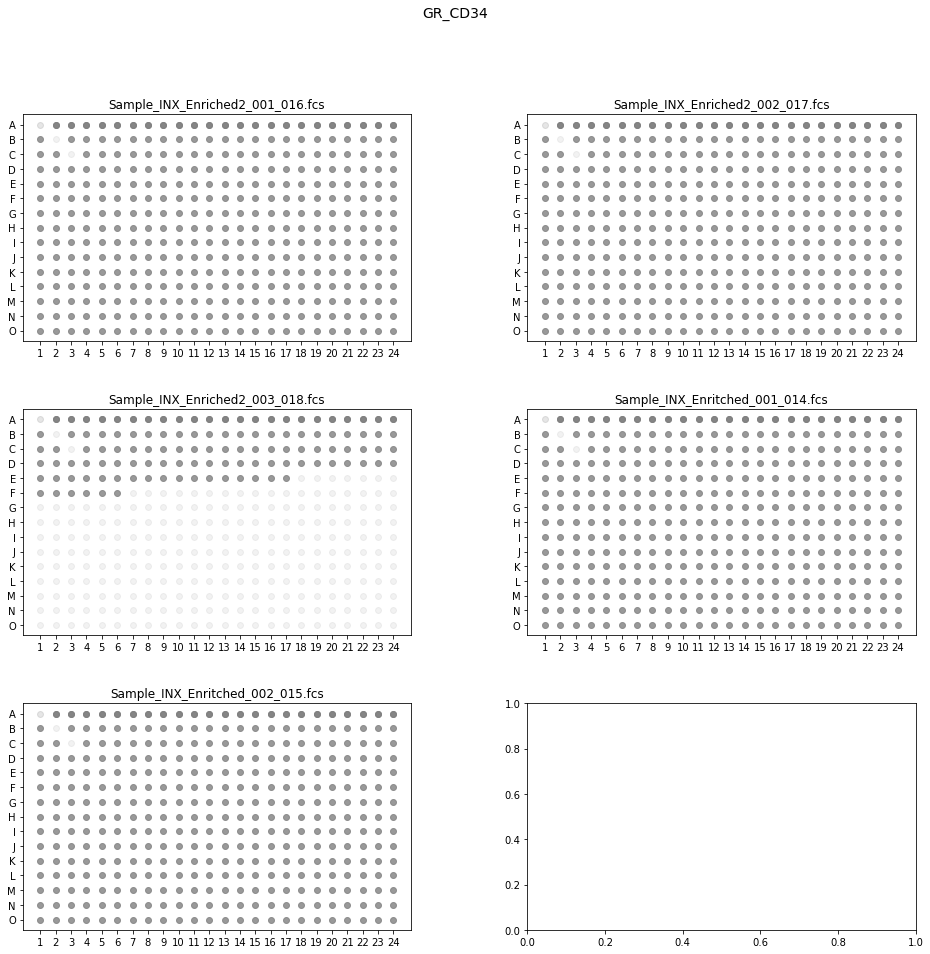

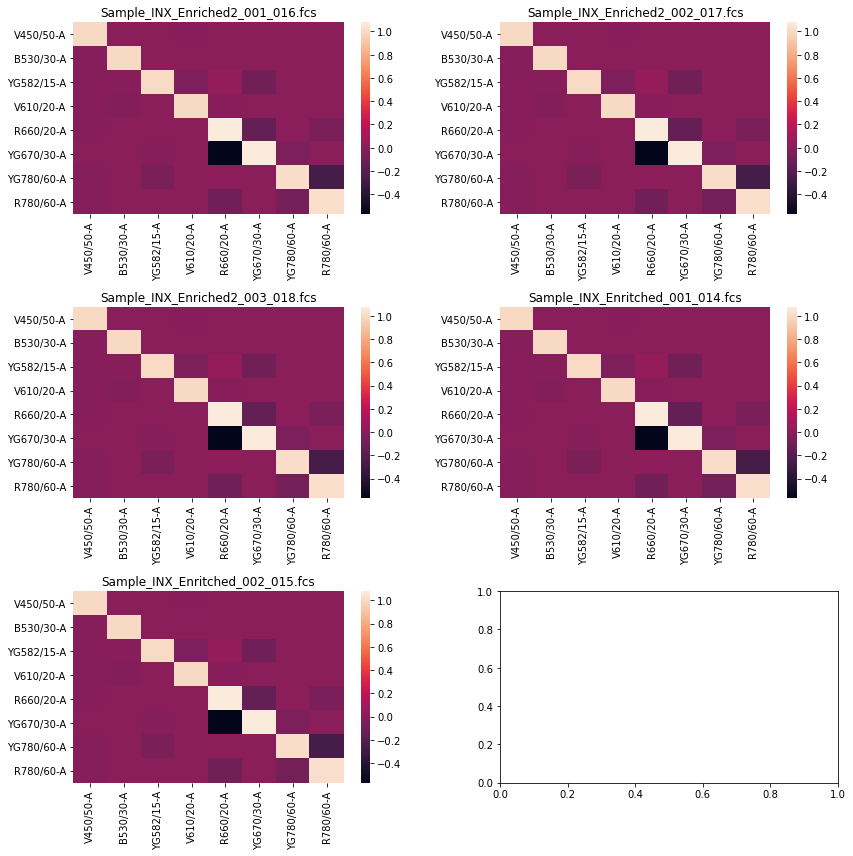

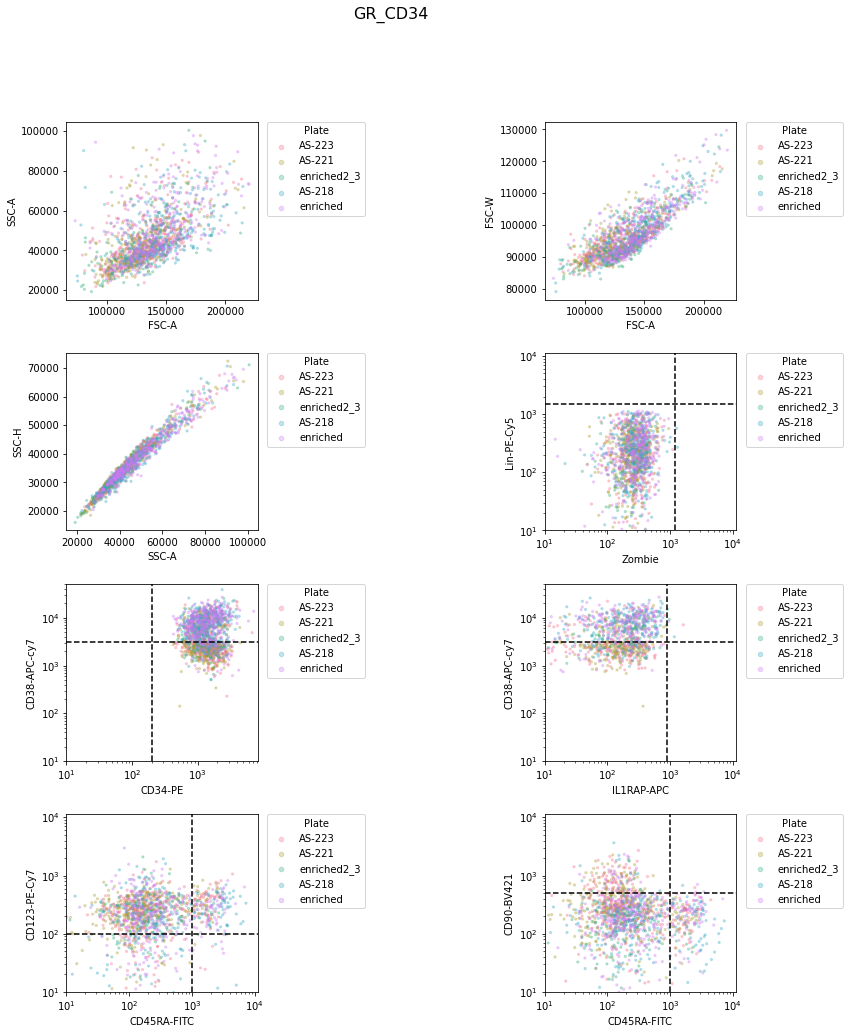

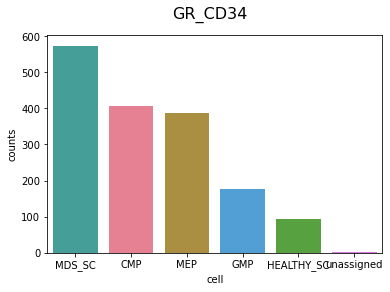

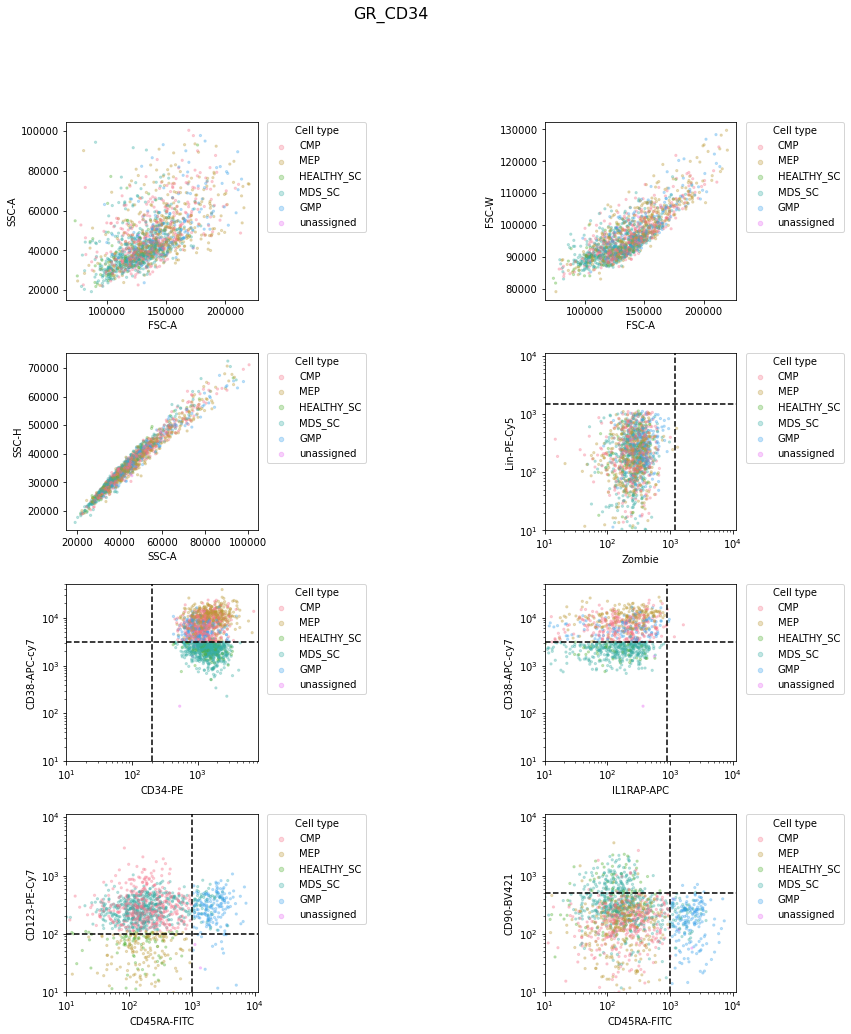

In [4]:
#GR CD34 parameters

directory = '../Data/GR_BM/Indexed/'

#Make plate key - note one plate split over 2 index files
files = []
for filename in os.listdir(directory):
    files.append(filename)

plates = ['AS-223', 'AS-221','enriched2_3', 'AS-218', 'enriched'] 

plate_key = dict(zip(files, plates))

channel_key = {'YG582/15-A': 'CD34-PE', 
               'YG670/30-A': 'Lin-PE-Cy5', 
               'YG780/60-A': 'CD123-PE-Cy7', 
               'V450/50-A': 'CD90-BV421', 
               'V610/20-A': 'Zombie', 
               'B530/30-A': 'CD45RA-FITC', 
               'R660/20-A': 'IL1RAP-APC', 
               'R780/60-A': 'CD38-APC-cy7'
}

logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'Lin-PE-Cy5'], 
    ['CD34-PE', 'CD38-APC-cy7'],
    ['IL1RAP-APC', 'CD38-APC-cy7'],
    ['CD45RA-FITC', 'CD123-PE-Cy7'],
    ['CD45RA-FITC', 'CD90-BV421']
]
#Tweak for GR
gates = {
    'Lin-PE-Cy5': 1500,
    'CD34-PE': 200 ,
    'CD38-APC-cy7': 3100 ,  #3100 = 10% on Flowjo, 3700 = 15% 
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 100,
    'Zombie': 1200,
    'IL1RAP-APC': 900,  #set from FlowJo looking at unstained, not convinced this worked
    'CD90-BV421': 500
}


label = 'GR_CD34'
plate_qc(directory, label)
source = get_comp_data(directory, plate_key, channel_key, plot = True)
flowplot_byplate(source, plot_list, logs, gates, label)
CD34assigned = MDS_BM_celltype_assign(source, gates, label, save = False)
flowplot_bycelltype(CD34assigned, plot_list, logs, gates,  label, plot = True, save = False)

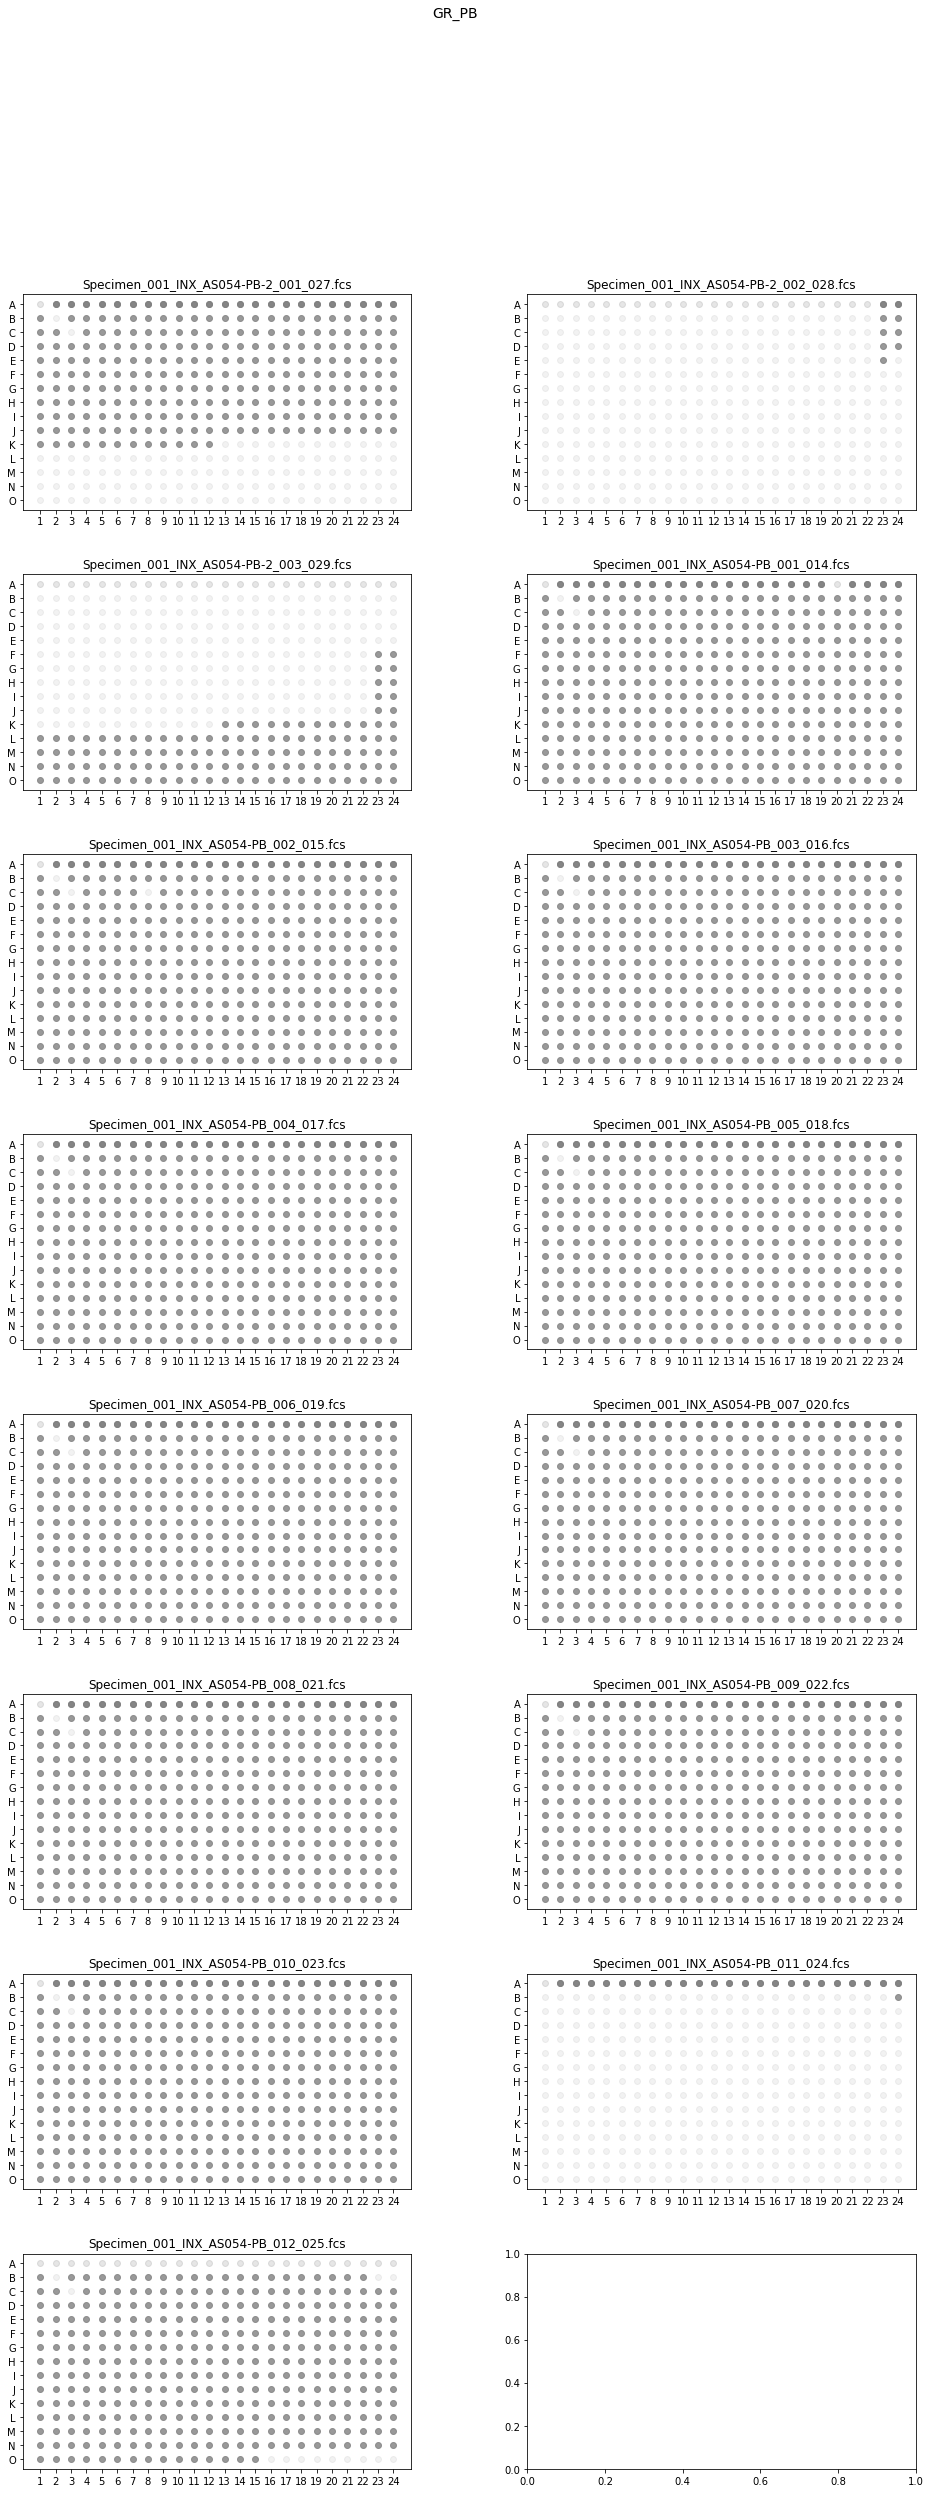

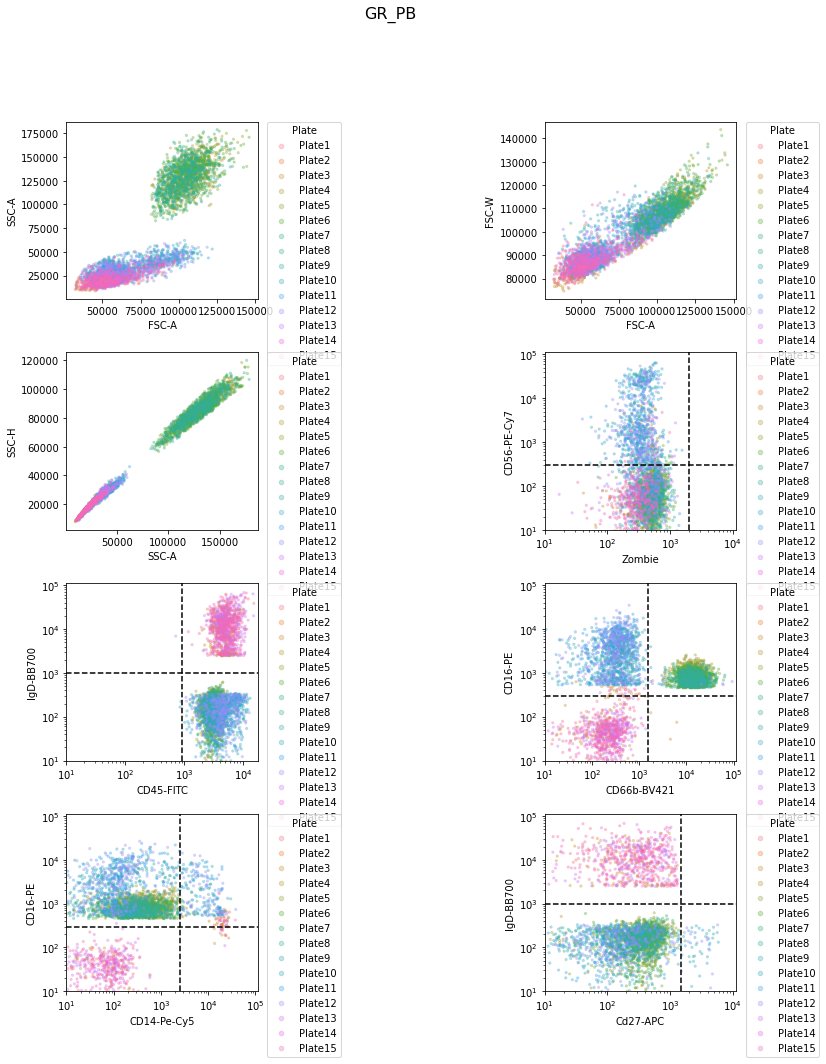

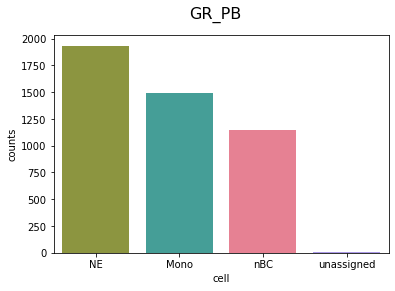

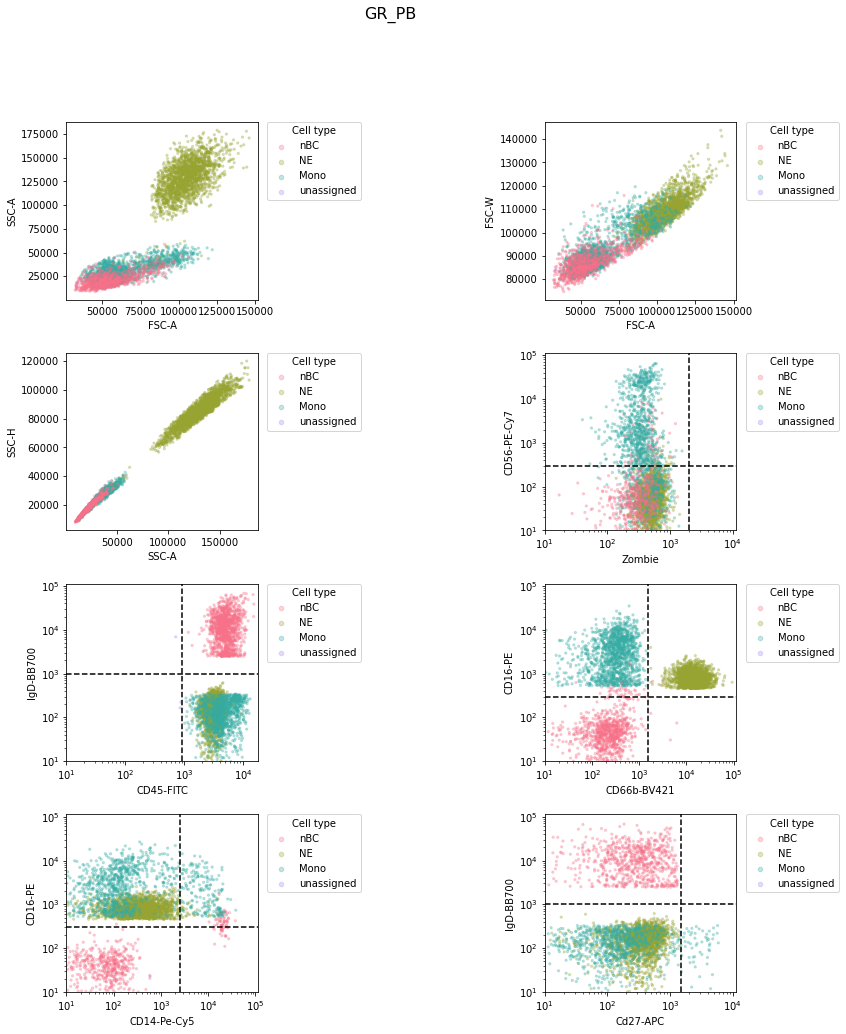

In [5]:
#GR PB parameters

directory = '../Data/GR_PB/Indexed/'

#Make plate key - note one plate split over 2 index files
files = []
for filename in os.listdir(directory):
    files.append(filename)
    
plates = ['Plate1', 'Plate2', 'Plate3', 'Plate4', 'Plate5', 'Plate6', 'Plate7', 'Plate8', 'Plate9', 'Plate10', 'Plate11', 'Plate12', 'Plate13','Plate14', 'Plate15'] 

plate_key = dict(zip(files, plates))

#Just using placeholder plate names for now
#NEs	1	Plate_1	381	Box_4	D7.6	
#NEs	2	Plate_2	381	used		AS215
#NEs	3	Plate_3	381	used		AS216
#NEs	4	Plate_4	381	Box_4	D7.6	
#NEs	5	Plate_5	381	Box_4	D7.6	
#Monocytes	1	Plate_6	381	used		AS217
#Monocytes	2	Plate_7	381	used		AS214
#Monocytes	3	Plate_8	381	Box_4	D7.6	
#Monocytes	4	Plate_9	381	Box_5	D7.7	
#nBCs	1	Plate_10	381	used		AS2019
#nBCs	2	Plate_11	381	Box_5	D7.7	
#nBCs	3	Plate_12	381	used		AS222

channel_key = {
    'YG582/15-A': 'CD16-PE', 
    'YG670/30-A': 'CD14-Pe-Cy5', 
    'YG780/60-A': 'CD56-PE-Cy7', 
    'V450/50-A': 'CD66b-BV421', 
    'V610/20-A': 'Zombie', 
    'B530/30-A': 'CD45-FITC', 
    'B695/40-A': 'IgD-BB700', 
    'R660/20-A': 'Cd27-APC'
}

logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']

plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'CD56-PE-Cy7'], 
    ['CD45-FITC', 'IgD-BB700'],
    ['CD66b-BV421', 'CD16-PE'],
    ['CD14-Pe-Cy5', 'CD16-PE'],
    ['Cd27-APC', 'IgD-BB700']
]

gates = {
    'CD16-PE': 300,
    'CD14-Pe-Cy5': 2500 ,
    'CD56-PE-Cy7': 300 ,
    'CD66b-BV421': 1500 ,
    'Zombie': 2000,
    'CD45-FITC': 900,
    'Cd27-APC': 1500,
    'IgD-BB700': 1000,
    'R780/60-A':1000
}


label = 'GR_PB'
plate_qc(directory, label)

source = get_comp_data(directory, plate_key, channel_key, plot = False)
flowplot_byplate(source, plot_list, logs, gates,label)
PBassigned = PB_celltype_assign(source, gates, label, save = False)
flowplot_bycelltype(PBassigned, plot_list, logs, gates,  label, plot = True, save = False)

In [6]:
#Now combine everything into a single df that contains the celltype and flow data for each well
print('Number of CD34 wells (expect 1640) = ', len(CD34assigned))
print('Number of PB wells (expect ?) = ',len(PBassigned))
GR_allcells_assigned = CD34assigned.append(PBassigned, ignore_index=True)
print('Total number of wells = ', len(GR_allcells_assigned))
#GR_alldata_comp_ct.to_csv(f'../Data/Amp_data/EL_comp_celltype_assignment.tsv', sep = '\t')    #Save the well assignment to a file


Number of CD34 wells (expect 1640) =  1640
Number of PB wells (expect ?) =  4578
Total number of wells =  6218
